#1. Ejemplo del método de clasificación Naive Bayes
#Crop mapping using fused optical-radar data set Data Set

Este gran conjunto de datos es un radar óptico bitemporal fusionado para la clasificación de tierras de cultivo. Las imágenes fueron recolectadas por satélites RapidEye (ópticos) y el sistema de radar de apertura sintética de vehículos aéreos no tripulados (UAVSAR) (Radar) sobre una región agrícola cerca de Winnipeg, Manitoba, Canadá en 2012.
Hay 2 * 49 funciones de radar y 2 * 38 funciones ópticas para dos fechas: 05 y 14 de julio de 2012.

Existen siete clases de tipos de cultivos para este conjunto de datos de la siguiente manera: 1-Maíz; 2-guisantes; 3- Canola; 4-soja; 5- Avena; 6- Trigo; y 7 de hoja ancha.





#2. Importación de librerías y montando google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2
import random
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier


In [3]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/7. Modelos de ensamble/7.2 Bagging'
train_path = os.path.join(path,'WinnipegDataset.txt')

# 3. Lectura y visualuzación del dataset

In [4]:
train_df = pd.read_csv(train_path)
clases = train_df['label'].unique()
train_df.dropna(axis=0, inplace=True)
train_df.head(10)

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,1,-13.559,-21.407,-11.4040,-15.248,-11.923,-15.291,-2.1548,-7.8474,-10.0020,0.04239,3.3253,3.3677,0.35631,0.058490,0.58520,0.24150,0.51934,0.23916,-0.62424,-0.81493,-0.70844,-0.65641,-0.19568,-0.63160,0.091945,0.026703,0.005017,0.62019,0.68370,44.369,0.42402,0.19617,0.25967,0.12013,0.054561,0.16226,-11.923,-12.823,-21.407,...,0.13580,0.650770,6711,6143,4570,5064,8212,0.28493,1.7969,1.3442,-0.61941,0.54346,0.42738,0.14683,0.144130,0.58593,0.23712,1.6216,0.23712,294110.0,0.051277,2199.4,92560.0,1.1081,48.444,3.13580,0.57778,2.44440,1.11110,1.8310,0.18519,0.72602,5.3333,6.000000,0.29489,9.77780,2.44440,1.67700,0.20988,0.65422
1,1,-12.802,-20.335,-10.3990,-14.132,-11.096,-14.361,-2.4039,-7.5330,-9.9369,0.22842,3.0360,3.2644,0.34295,0.060525,0.59652,0.25249,0.50796,0.23955,-0.57229,-0.74854,-0.64839,-0.62810,-0.18825,-0.55448,0.115710,0.031183,0.006051,0.60356,0.67496,44.992,0.40738,0.19618,0.26758,0.12886,0.052298,0.15826,-11.096,-11.805,-20.335,...,0.30864,0.104830,6274,5084,3297,3777,8214,0.42716,2.4914,1.5420,-0.64500,0.92501,0.64071,0.21322,0.235370,0.75089,0.37003,2.1747,0.37003,412400.0,0.067854,2338.4,100280.0,1.1456,49.778,0.39506,0.46667,1.33330,1.11110,1.2149,0.33333,-0.48751,2.1111,0.098765,0.83333,0.33333,0.33333,0.84869,0.50617,-0.18898
2,1,-12.431,-19.902,-10.0740,-13.598,-10.829,-14.048,-2.3566,-7.4717,-9.8283,0.44978,2.7687,3.2185,0.34489,0.061731,0.59338,0.26362,0.49870,0.23768,-0.53347,-0.70253,-0.58846,-0.61836,-0.17804,-0.48642,0.127130,0.032382,0.006162,0.58683,0.68024,45.466,0.39919,0.18764,0.28105,0.13211,0.048473,0.14878,-10.829,-11.377,-19.902,...,0.30864,0.613940,6215,5035,3033,3837,8588,0.47801,2.8315,1.6601,-0.70049,1.03530,0.71699,0.24814,0.260810,0.80946,0.38237,2.2382,0.38237,439570.0,0.117030,3321.3,128320.0,1.2651,49.444,0.24691,0.61111,0.77778,0.77778,1.3689,0.25926,0.25298,2.2222,0.172840,0.68889,0.88889,0.66667,1.27300,0.30864,0.10483
3,1,-12.689,-19.529,-10.0280,-13.350,-11.056,-14.014,-2.6611,-6.8396,-9.5006,0.66378,2.2942,2.9580,0.32760,0.067825,0.60457,0.28135,0.47717,0.24148,-0.50405,-0.66998,-0.52543,-0.61169,-0.17507,-0.43576,0.127200,0.031091,0.006040,0.57769,0.67468,46.654,0.38976,0.18793,0.28492,0.13738,0.047480,0.14701,-11.056,-11.263,-19.529,...,0.16049,0.064018,6836,5745,4212,4534,7691,0.29228,1.8260,1.3640,-0.47512,0.65772,0.43840,0.15396,0.144830,0.60147,0.25824,1.6963,0.25824,296240.0,0.036817,1748.1,80640.0,1.0764,50.667,0.88889,0.61111,0.77778,0.77778,1.8892,0.16049,0.43750,4.1111,0.320990,0.83333,0.33333,0.33333,1.14910,0.38272,0.41603
4,1,-12.686,-19.278,-9.8185,-13.108,-10.932,-13.939,-2.8675,-6.5919,-9.4594,0.83143,2.1756,3.0070,0.31701,0.069483,0.61351,0.28768,0.47476,0.23756,-0.50314,-0.68221,-0.50731,-0.59134,-0.17505,-0.45195,0.131550,0.031960,0.006439,0.57937,0.66460,46.828,0.38505,0.19432,0.27955,0.14108,0.048950,0.15156,-10.932,-11.109,-19.278,...,0.20988,0.657600,6682,5883,4434,4627,7072,0.22927,1.5949,1.3268,-0.40120,0.52776,0.34389,0.14045,0.091779,0.53551,0.20899,1.5284,0.20899,232610.0,0.021300,1365.4,69540.0,1.0435,51.222,0.39506,0.56667,1.66670,1.00000,1.7351,0.18519,0.35000,4.0000,0.444440,0.68889,0.88889,0.66667,1.58110,0.20988,0.50000
5,1,-12.478,-19.034,-9.6201,-12.888,-10.761,-13.687,-2.8583,-6.5555,-9.4138,0.79854,2.1276,2.9261,0.31723,0.070118,0.61265,0.28867,0.47115,0.24018,-0.49984,-0.69457,-0.50160,-0.58093,-0.17393,-0.45870,0.138010,0.033254,0.006886,0.57967,0.65689,47.061,0.38078,0.19889,0.27611,0.14422,0.049898,0.15462,-10.761,-10.877,-19.034,...,0.30864,0.316230,6424,5297,3248,3956,8504,0.44724,2.6182,1.6308,-0.65091,0.98321,0.67084,0.23979,0.232370,0.79120,0.36501,2.1496,0.36501,422730.0,0.09

#3. Escalamiento y codificación de etiquetas

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df.loc[:, train_df.columns != 'label'] = scaler.fit_transform(train_df.loc[:, train_df.columns != 'label'])

In [8]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df.label.values)
train_df.head(10)

,label,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174
0,0,0.392808,0.482842,0.484525,0.428160,0.479835,0.416751,0.271778,0.561445,0.419359,0.424448,0.490980,0.526143,0.241287,0.167421,0.711752,0.475055,0.522199,0.456485,0.937061,0.940278,0.922269,0.942901,0.916921,0.939970,0.035091,0.030971,0.042327,0.503102,0.653615,0.481939,0.589015,0.272859,0.473394,0.281261,0.135198,0.210442,0.479835,0.416637,0.482842,...,0.027776,0.825385,0.137931,0.218813,0.275003,0.414860,0.338914,0.453397,0.158635,0.248673,0.354784,0.273270,0.453391,0.349319,0.519405,0.626457,0.424767,0.231065,0.424767,0.261680,0.299290,0.424037,0.335638,0.184375,0.632772,0.033430,0.565724,0.018121,0.119047,0.833333,0.083340,0.863010,0.428584,0.231205,0.211119,0.146666,0.366658,0.763244,0.111116,0.827110
1,0,0.421367,0.522963,0.525943,0.467989,0.518816,0.450145,0.252028,0.582111,0.423523,0.453058,0.472308,0.519234,0.219376,0.175362,0.730802,0.504565,0.505937,0.457575,0.944953,0.949270,0.930255,0.946703,0.920592,0.950705,0.044838,0.036870,0.051542,0.476375,0.643011,0.493130,0.558581,0.272874,0.489269,0.303668,0.128726,0.204455,0.518816,0.452897,0.522963,...,0.222221,0.552415,0.088362,0.092396,0.126097,0.209662,0.339045,0.620630,0.271073,0.405371,0.354766,0.466252,0.620614,0.525109,0.633085,0.792795,0.644545,0.424602,0.644545,0.369264,0.331180,0.433279,0.354437,0.207656,0.672136,0.004212,0.451441,0.009884,0.119047,0.552931,0.249997,0.256245,0.169648,0.003806,0.813529,0.005000,0.049999,0.386260,0.444442,0.405510
2,0,0.435363,0.539169,0.539336,0.487047,0.531401,0.461385,0.255778,0.586140,0.430470,0.487101,0.455057,0.516164,0.222558,0.180068,0.725518,0.534450,0.492705,0.452348,0.950849,0.955503,0.938225,0.948012,0.925637,0.960180,0.049522,0.038449,0.052530,0.449487,0.649417,0.501644,0.543602,0.259627,0.516304,0.312010,0.117787,0.190268,0.531401,0.468142,0.539169,...,0.222221,0.806970,0.081670,0.086546,0.095216,0.219228,0.363601,0.680420,0.326134,0.498931,0.354727,0.522034,0.680408,0.617572,0.664781,0.851853,0.664950,0.446822,0.664950,0.393975,0.425782,0.498630,0.422714,0.281843,0.662280,0.002632,0.600006,0.005766,0.083334,0.623020,0.166669,0.626490,0.178576,0.006660,0.651928,0.013333,0.100000,0.579374,0.222221,0.552415
3,0,0.425630,0.553129,0.541232,0.495897,0.520702,0.462606,0.231635,0.627688,0.451431,0.520013,0.424432,0.498739,0.194201,0.203848,0.744350,0.582058,0.461940,0.462970,0.955318,0.959912,0.946607,0.948907,0.927104,0.967232,0.049551,0.036749,0.051437,0.434798,0.642671,0.522982,0.526355,0.260077,0.524071,0.325536,0.114948,0.187619,0.520702,0.472203,0.553129,...,0.055552,0.532009,0.152110,0.171302,0.233127,0.330357,0.304708,0.462040,0.163346,0.264359,0.354886,0.331061,0.462029,0.368198,0.520278,0.642127,0.459691,0.257204,0.459691,0.263617,0.271473,0.394031,0.306613,0.164696,0.698368,0.009476,0.600006,0.005766,0.083334,0.859822,0.055552,0.718750,0.330368,0.012369,0.813529,0.005000,0.049999,0.522984,0.305561,0.708015
4,0,0.425743,0.562523,0.549866,0.504534,0.526546,0.465299,0.215271,0.643970,0.454067,0.545796,0.416777,0.502017,0.176832,0.210318,0.759395,0.599055,0.458496,0.452012,0.955456,0.958255,0.949017,0.951641,0.927114,0.964978,0.051335,0.037893,0.054999,0.437498,0.630440,0.526108,0.517741,0.269989,0.513294,0.335032,0.119151,0.194429,0.526546,0.477688,0.562523,...,0.111116,0.828800,0.134642,0.187776,0.259095,0.345185,0.264067,0.387953,0.125932,0.234889,0.354938,0.265329,0.387946,0.332426,0.454179,0.575617,0.378251,0.198453,0.378251,0.205746,0.241622,0.368586,0.279585,0.144271,0.714745,0.004212,0.554297,0.012356,0.107143,0.789687,0.083340,0.675000,0.321440,0.017126,0.651928,0.013333,0.100000,0.719598,0.111116,0.750000
5,0,0.433590,0.571655,0.558042,0.512386,0.53460

#4.  Selección de características

In [9]:
fs = SelectKBest(score_func=f_classif, k=25)
np_X = train_df.iloc[:, 1:].to_numpy()
np_Y = train_df.iloc[:, 0].to_numpy()
X_selec = fs.fit_transform(np_X, np_Y)
attr_names = train_df.columns.values.tolist()
# Lista de bools que indican si es un atributo seleccionado o no
mask = fs.get_support()
# Lista de los K mejores atributos
new_features = [] 
for bool, feature in zip(mask, attr_names):
    if bool:
        new_features.append(feature)
new_train_df = pd.DataFrame(X_selec, columns=new_features)
new_train_df['label'] = train_df['label']

In [10]:
new_train_df.head(10)

,label,f1,f3,f4,f36,f38,f39,f40,f44,f49,f50,f51,f53,f74,f85,f87,f88,f89,f91,f93,f94,f99,f101,f137,f139
0,0,0.482842,0.428160,0.479835,0.479835,0.482842,0.209498,0.122304,0.035103,0.440669,0.452456,0.534394,0.509391,0.046465,0.509391,0.452456,0.200807,0.107017,0.073944,0.026463,0.077241,0.164706,0.480938,0.218813,0.414860
1,0,0.522963,0.467989,0.518816,0.518816,0.522963,0.232386,0.136083,0.044802,0.476828,0.478708,0.575961,0.552566,0.057913,0.552566,0.478708,0.229910,0.121106,0.093379,0.030879,0.096979,0.126471,0.299120,0.092396,0.209662
2,0,0.539169,0.487047,0.531401,0.531401,0.539169,0.243892,0.144625,0.052991,0.495501,0.484807,0.591785,0.573132,0.062550,0.573132,0.484807,0.252079,0.131077,0.109867,0.033446,0.113389,0.132353,0.310850,0.086546,0.219228
3,0,0.553129,0.495897,0.520702,0.520702,0.553129,0.247645,0.148179,0.058290,0.500178,0.486517,0.605395,0.585307,0.063152,0.585307,0.486517,0.267121,0.136140,0.122055,0.034550,0.126270,0.205882,0.348974,0.171302,0.330357
4,0,0.562523,0.504534,0.526546,0.526546,0.562523,0.249619,0.151980,0.063141,0.512015,0.491463,0.616381,0.598198,0.067113,0.598198,0.491463,0.279634,0.141540,0.132314,0.036394,0.137153,0.191176,0.381232,0.187776,0.345185
5,0,0.571655,0.512386,0.534606,0.534606,0.571655,0.255239,0.157830,0.066167,0.522521,0.503027,0.626097,0.608939,0.071598,0.608939,0.503027,0.291701,0.148455,0.142684,0.038561,0.147879,0.158824,0.354839,0.117823,0.238202
6,0,0.572217,0.516740,0.539178,0.539178,0.572217,0.257195,0.162878,0.067584,0.536132,0.507935,0.635197,0.622456,0.075148,0.622456,0.507935,0.300613,0.152754,0.150566,0.040037,0.155923,0.147059,0.337243,0.091321,0.224171
7,0,0.570794,0.512421,0.532909,0.532909,0.570794,0.258270,0.167095,0.066648,0.534711,0.505035,0.640854,0.624925,0.075118,0.624925,0.505035,0.303812,0.153401,0.153774,0.039505,0.159016,0.135294,0.325513,0.092635,0.229592
8,0,0.565368,0.511779,0.534559,0.534559,0.565368,0.257671,0.169312,0.065289,0.531480,0.496073,0.636304,0.621164,0.073082,0.621164,0.496073,0.301729,0.152301,0.152046,0.038487,0.156690,0.152941,0.322581,0.082488,0.222258
9,0,0.562710,0.510637,0.532674,0.532674,0.562710,0.259732,0.172242,0.063871,0.529933,0.495032,0.632492,0.618273,0.071704,0.618273,0.495032,0.296447,0.151355,0.147455,0.037464,0.152036,0.105882,0.293255,0.076638,0.199777


#5. Dividiendo el conjunto en entrenamiento y prueba

In [12]:
X = np.array(new_train_df.iloc[:,1:])
y = np.array(new_train_df['label'])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.75, random_state = 0)

print(f'Dimension de los datos de entrenamiento {X_train.shape}')
print(f'Dimension de los datos de prueba {X_test.shape}')

Dimension de los datos de entrenamiento (81458, 24)
Dimension de los datos de prueba (244376, 24)


#6. Entrenando y prediciendo con CART

In [18]:
seed = 10
n_classes = 7
dectree = DecisionTreeClassifier(max_depth= 50, random_state=seed)
dectree = dectree.fit(X_train,y_train)

In [19]:
y_pred = dectree.predict(X_test)

In [20]:
score = metrics.accuracy_score(y_test, y_pred)
print("Test Acc: %s"%score)

Test Acc: 0.9722026712934168


In [21]:
#Funciones para MC y métricas
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')#, fontsize=10)
    plt.xlabel('Clase Predicha')#, fontsize=10)
    plt.savefig(title+'.png')
    #plt.grid(b=None)
    plt.show()
def sens_spec(cls_names, y_true, y_pred, pesos):
  sensitivity = []
  specificity = []
  prec=[]
  fscore = []
  sd = []
  for i,name in enumerate(cls_names):
    TP = np.sum((y_true==name) & (y_pred==name))
    TN = np.sum((y_true!=name) & (y_pred!=name))
    FP = np.sum((y_true!=name) & (y_pred==name))
    FN = np.sum((y_true==name) & (y_pred!=name))
    sensitivity.append(TP/(TP+FN))
    specificity.append(FP/(TN+FP))
    prec.append(TP/(TP+FP))
    fscore.append(2*(prec[i]*sensitivity[i])/(prec[i]+sensitivity[i]))
  sensitivity.append(sum([x*y for x,y in zip(sensitivity,pesos)]))
  specificity.append(sum([x*y for x,y in zip(specificity,pesos)]))
  prec.append(sum([x*y for x,y in zip(prec,pesos)]))
  fscore.append(sum([x*y for x,y in zip(fscore,pesos)]))
  for i in range(len(cls_names)):
    sd.append(np.sqrt((sensitivity[i]-sensitivity[-1])**2))
  sd.append(np.nan)
  return sensitivity, specificity, prec, fscore, sd

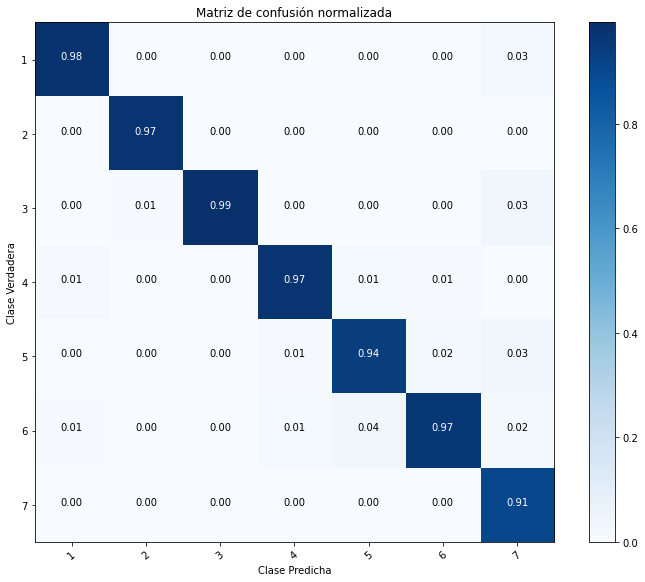

In [22]:
predictions = np.float32(y_pred)
true_labels = np.float32(y_test)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_classes))
tit = 'Matriz de confusión árbol de decisión (CART)'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=True)

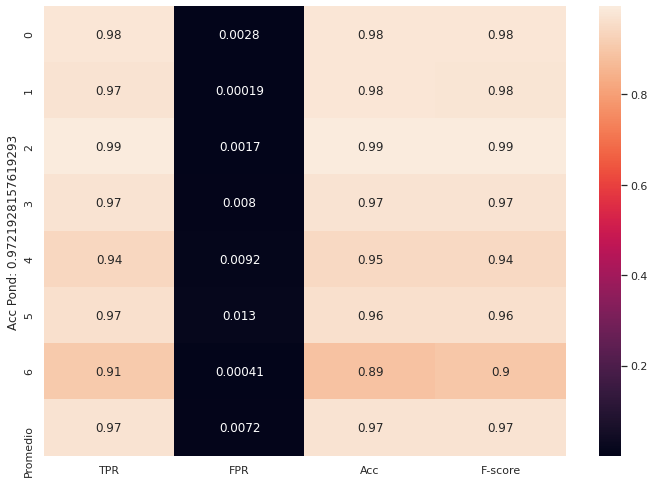

In [24]:
clases = train_df['label'].unique().tolist()
n_clases = len(clases)
pesos = train_df['label'].value_counts().sort_index().tolist()/ np.sum(train_df['label'].value_counts().tolist())
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)

#7. Entrenando y prediciendo con Bagging

In [27]:
cart =  DecisionTreeClassifier(random_state=seed)
bagging = BaggingClassifier(base_estimator=cart,n_estimators=20, random_state=0).fit(X_train, y_train)
y_pred = bagging.predict(X_test)

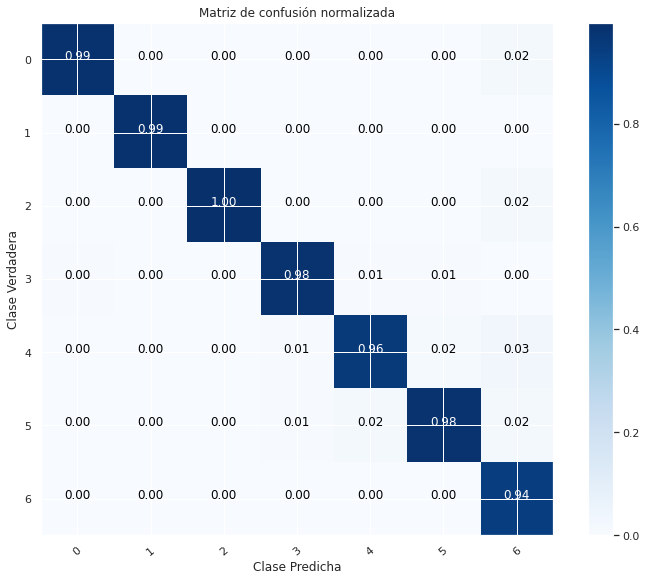

In [28]:
predictions = np.float32(y_pred)
true_labels = np.float32(y_test)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_classes))
tit = 'Matriz de confusión AdaBoost'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=True)

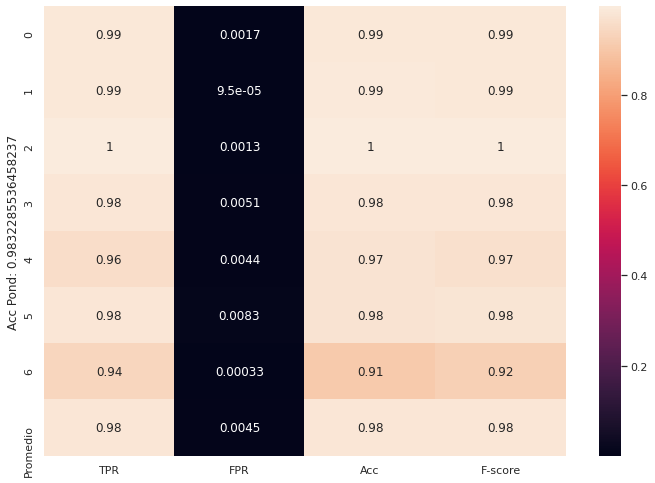

In [29]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)